<a href="https://colab.research.google.com/github/samuel-verburg/EEA-summer-school-2025/blob/main/exercise2_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

In [120]:
class Sin(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

class FCN(nn.Module):
    """Fully Connected Network."""
    def __init__(self, n_in, n_out, n_units, n_layers):
        super().__init__()
        # activation = nn.Tanh
        activation = Sin

        self.fcs = nn.Sequential(*[
                        nn.Linear(n_in, n_units),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                        nn.Linear(n_units, n_units),
                        activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_units, n_out)
    def forward(self, r):
        r = self.fcs(r)
        r = self.fch(r)
        r = self.fce(r)
        return r

In [121]:
# Define parameters
c = 343.0
f = 1000.0
k = 2 * np.pi * f / c
L = 1.0
T = 1e-3

r = np.linspace(0.1, L, 50)
t = np.linspace(0, T, 50)
r_grid, t_grid = np.meshgrid(r, t)
rt = np.array([r_grid.flatten(), t_grid.flatten()]).T

p_ref = np.exp(1j * (2 * np.pi * f * rt[:, 1] - k * rt[:, 0])) / (4 * np.pi * rt[:, 0])
p_ref = p_ref.real.reshape(r_grid.shape)

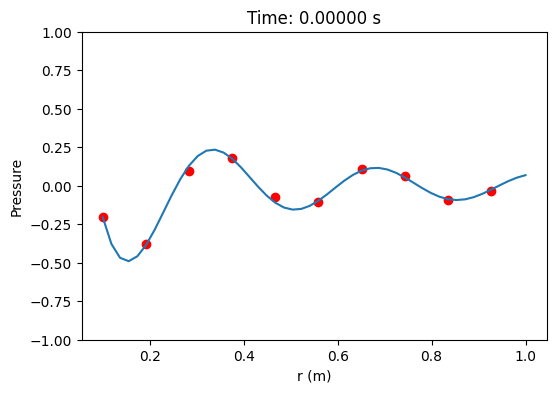

In [122]:
p_obs = p_ref[:, 0:50:5].copy()
p_obs += 0.1 * np.random.randn(p_obs.shape[0],p_obs.shape[1]) * np.sqrt(np.mean(np.abs(p_obs)**2))
r_obs = r[0:50:5]
rt_obs = np.array([r_grid[:, 0:50:5].flatten(), t_grid[:, 0:50:5].flatten()]).T

fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_ref[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line.set_ydata(p_ref[frame, :])
    for coll in plt.gca().collections:
        coll.remove()
    plt.scatter(r_obs, p_obs[frame, :], color='red', label='Observations')
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line,

ani = FuncAnimation(fig, update, frames=p_ref.shape[0], interval=100, blit=True)
# ani.save('wave_animation.gif', writer='pillow', fps=10)
# ani

In [123]:
n_in = 2
n_out = 1
n_hidden = 32
n_layers = 3
n_epochs = int(4e4)

rt_obs = torch.tensor(rt_obs, dtype=torch.float32).requires_grad_(True)
p_obs = torch.tensor(p_obs.reshape(-1,1), dtype=torch.float32).requires_grad_(True)
rt = torch.tensor(rt, dtype=torch.float32).requires_grad_(True)

model = FCN(n_in, n_out, n_hidden, n_layers)

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    p = model(rt_obs)
    loss = mse_loss(p, p_obs)

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
    loss_history.append(loss.item())

    if i % 1000 == 0:
      print(loss)


  0%|          | 55/20000 [00:00<01:11, 278.23it/s]

tensor(0.0982, grad_fn=<MseLossBackward0>)


  5%|▌         | 1049/20000 [00:03<00:44, 422.09it/s]

tensor(0.0516, grad_fn=<MseLossBackward0>)


 10%|█         | 2045/20000 [00:05<00:42, 426.78it/s]

tensor(0.0516, grad_fn=<MseLossBackward0>)


 15%|█▌        | 3084/20000 [00:07<00:37, 452.56it/s]

tensor(0.0513, grad_fn=<MseLossBackward0>)


 20%|██        | 4076/20000 [00:09<00:36, 441.12it/s]

tensor(0.0508, grad_fn=<MseLossBackward0>)


 25%|██▌       | 5059/20000 [00:12<00:34, 437.88it/s]

tensor(0.0508, grad_fn=<MseLossBackward0>)


 30%|███       | 6046/20000 [00:15<00:51, 270.16it/s]

tensor(0.0502, grad_fn=<MseLossBackward0>)


 35%|███▌      | 7098/20000 [00:17<00:27, 470.41it/s]

tensor(0.0327, grad_fn=<MseLossBackward0>)


 40%|████      | 8055/20000 [00:19<00:26, 448.31it/s]

tensor(0.0297, grad_fn=<MseLossBackward0>)


 45%|████▌     | 9072/20000 [00:22<00:23, 469.79it/s]

tensor(0.0279, grad_fn=<MseLossBackward0>)


 50%|█████     | 10012/20000 [00:24<00:27, 359.11it/s]

tensor(0.0242, grad_fn=<MseLossBackward0>)


 55%|█████▌    | 11036/20000 [00:27<00:28, 313.55it/s]

tensor(0.0178, grad_fn=<MseLossBackward0>)


 60%|██████    | 12097/20000 [00:30<00:16, 470.95it/s]

tensor(0.0078, grad_fn=<MseLossBackward0>)


 65%|██████▌   | 13062/20000 [00:32<00:14, 479.78it/s]

tensor(0.0055, grad_fn=<MseLossBackward0>)


 70%|███████   | 14091/20000 [00:34<00:12, 481.89it/s]

tensor(0.0043, grad_fn=<MseLossBackward0>)


 75%|███████▌  | 15094/20000 [00:36<00:10, 472.39it/s]

tensor(0.0035, grad_fn=<MseLossBackward0>)


 80%|████████  | 16044/20000 [00:38<00:10, 371.00it/s]

tensor(0.0027, grad_fn=<MseLossBackward0>)


 85%|████████▌ | 17073/20000 [00:41<00:06, 439.73it/s]

tensor(0.0019, grad_fn=<MseLossBackward0>)


 90%|█████████ | 18072/20000 [00:44<00:04, 463.50it/s]

tensor(0.0016, grad_fn=<MseLossBackward0>)


 95%|█████████▌| 19065/20000 [00:46<00:02, 379.67it/s]

tensor(0.0014, grad_fn=<MseLossBackward0>)


100%|██████████| 20000/20000 [00:49<00:00, 406.95it/s]


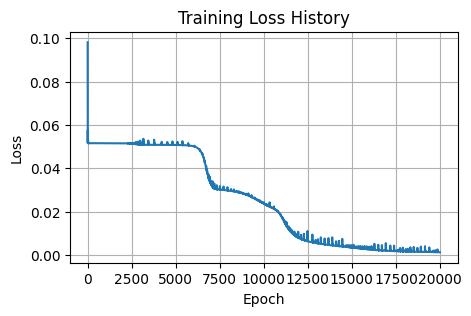

In [124]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

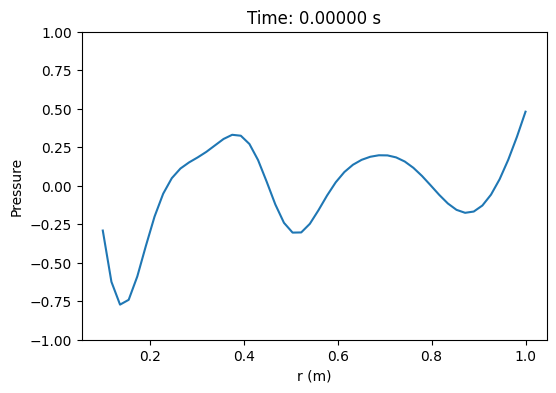

In [125]:
p_rec = model(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line,

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
# ani.save('wave_animation_model.gif', writer='pillow', fps=10)
# ani

In [131]:
def pde_residual(p, rt, c):
    p_rt = torch.autograd.grad(p, rt, torch.ones_like(p), create_graph=True)[0]
    p_rr = torch.autograd.grad(p_rt[:,0], rt, torch.ones_like(p_rt[:,0]), create_graph=True)[0][:,0:1]
    p_tt = torch.autograd.grad(p_rt[:,1], rt, torch.ones_like(p_rt[:,1]), create_graph=True)[0][:,1:2]
    pde_res = p_rr - p_tt / c**2
    return pde_res

alpha = 1e-3
model_pinn = FCN(n_in, n_out, n_hidden, n_layers)
# model_pinn = model
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)

n_epochs = int(4e4)


In [132]:

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    p = model_pinn(rt_obs)
    loss_obs = mse_loss(p, p_obs)

    if i < int(n_epochs/2):
      loss_pde = loss_obs*0
    else:
      r_colloc = torch.randn_like(rt_obs, dtype=torch.float32, requires_grad=True) * torch.tensor([L, T])
      p = model(r_colloc)
      loss_pde = mse_loss(pde_residual(p, r_colloc, c), torch.zeros_like(p))

      # p = model_pinn(rt)
      # loss_pde = mse_loss(pde_residual(p, rt, c), torch.zeros_like(p))

    loss = loss_obs + loss_pde*alpha

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
        loss_obs_history = []
        loss_pde_history = []

    loss_history.append(loss.item())
    loss_obs_history.append(loss_obs.item())
    loss_pde_history.append(loss_pde.item())

    if i % 1000 == 0:
      print(loss)


  0%|          | 59/20000 [00:00<01:07, 294.79it/s]

tensor(0.1149, grad_fn=<AddBackward0>)


  5%|▌         | 1067/20000 [00:03<00:44, 421.08it/s]

tensor(0.0516, grad_fn=<AddBackward0>)


 10%|█         | 2049/20000 [00:05<00:43, 415.60it/s]

tensor(0.0515, grad_fn=<AddBackward0>)


 15%|█▌        | 3074/20000 [00:07<00:38, 440.18it/s]

tensor(0.0509, grad_fn=<AddBackward0>)


 20%|██        | 4063/20000 [00:10<00:38, 417.83it/s]

tensor(0.0507, grad_fn=<AddBackward0>)


 25%|██▌       | 5041/20000 [00:12<00:45, 325.92it/s]

tensor(0.0420, grad_fn=<AddBackward0>)


 30%|███       | 6047/20000 [00:16<00:37, 370.73it/s]

tensor(0.0305, grad_fn=<AddBackward0>)


 35%|███▌      | 7067/20000 [00:18<00:31, 411.61it/s]

tensor(0.0294, grad_fn=<AddBackward0>)


 40%|████      | 8066/20000 [00:20<00:30, 397.18it/s]

tensor(0.0275, grad_fn=<AddBackward0>)


 45%|████▌     | 9067/20000 [00:23<00:26, 417.06it/s]

tensor(0.0231, grad_fn=<AddBackward0>)


 50%|█████     | 10011/20000 [00:26<00:44, 225.49it/s]

tensor(0.0596, grad_fn=<AddBackward0>)


 55%|█████▌    | 11013/20000 [00:37<01:33, 96.01it/s]

tensor(0.0651, grad_fn=<AddBackward0>)


 60%|██████    | 12011/20000 [00:48<01:25, 93.15it/s]

tensor(0.0569, grad_fn=<AddBackward0>)


 65%|██████▌   | 13017/20000 [01:00<01:13, 95.00it/s]

tensor(0.0526, grad_fn=<AddBackward0>)


 70%|███████   | 14018/20000 [01:12<01:01, 97.15it/s]

tensor(0.0444, grad_fn=<AddBackward0>)


 75%|███████▌  | 15014/20000 [01:23<00:53, 92.89it/s]

tensor(0.0409, grad_fn=<AddBackward0>)


 80%|████████  | 16020/20000 [01:35<00:41, 96.77it/s]

tensor(0.0487, grad_fn=<AddBackward0>)


 85%|████████▌ | 17014/20000 [01:47<00:34, 86.32it/s]

tensor(0.0405, grad_fn=<AddBackward0>)


 90%|█████████ | 18012/20000 [01:58<00:29, 66.95it/s]

tensor(0.0399, grad_fn=<AddBackward0>)


 95%|█████████▌| 19006/20000 [02:09<00:11, 85.69it/s]

tensor(0.0464, grad_fn=<AddBackward0>)


100%|██████████| 20000/20000 [02:20<00:00, 141.86it/s]


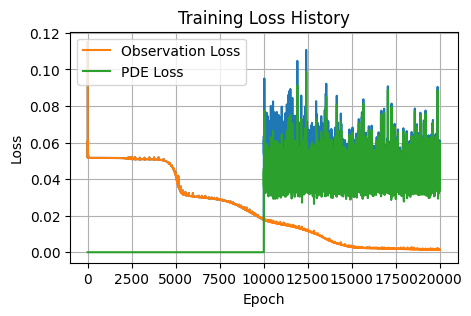

In [133]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.plot(np.array(loss_obs_history), label='Observation Loss')
plt.plot(np.array(loss_pde_history)*alpha, label='PDE Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

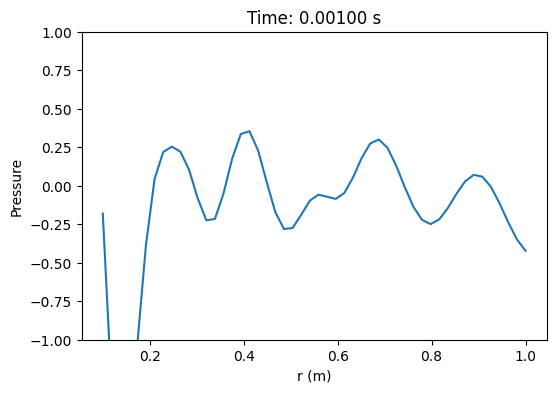

In [134]:
p_rec = model_pinn(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line,

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
# ani.save('wave_animation_pinn.gif', writer='pillow', fps=10)
ani

Estimate the speed of sound